## River Footprint using Satellite Imagery

In this project, we will leverage 4-band satellite imagery, encompassing RGB and Near-Infrared (NIR) channels, to identify river footprints. The dataset comprises input images, while the corresponding output is represented by binary images. Pixels with a value of 0 signify areas devoid of water bodies, whereas pixels with a value of 1 indicate the presence of river footprints. This approach combines spectral information from multiple bands to create an accurate delineation of river features in the landscape.

In [1]:
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# connect google drive
from google.colab import drive
drive.mount("/content/gdrive")

In [3]:
# set the working directory
import os
os.chdir(r'/content/drive/MyDrive/datasets')

## Data preprocessing

In [4]:
train_xx_initial = np.load('X_train.npy')
train_yy_initial = np.load('y_train.npy')
test_xx = np.load('X_test.npy')
test_yy = np.load("y_test.npy")

print(train_xx_initial.shape, train_yy_initial.shape, test_xx.shape, test_yy.shape)

(2709, 100, 100, 3) (2709, 100, 100, 3) (301, 100, 100, 3) (301, 100, 100, 3)


### Data Agumentation

In [5]:
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import numpy as np

# Define augmentation pipeline
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    iaa.Flipud(0.5),  # Vertical flip
    iaa.Affine(rotate=(-45, 45)),  # Random rotation between -45 and 45 degrees
    iaa.Affine(scale=(0.5, 1.5)),  # Random scaling between 0.5x and 1.5x
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),  # Random translation
    # iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Gaussian noise
    # iaa.ElasticTransformation(alpha=50, sigma=5)  # Elastic deformation
])

In [6]:
augmented_images = []
augmented_masks = []

num_augmentations = 3
# Apply augmentation to each original image and mask
for i in range(train_xx_initial.shape[0]):
    image = train_xx_initial[i]
    mask = train_yy_initial[i]

    # Create a segmentation map object from the mask
    segmentation_map = SegmentationMapsOnImage(mask, shape=image.shape)

    # Apply augmentation num_augmentations times
    for _ in range(num_augmentations):
        # Apply the same augmentation to both image and mask
        augmented_image, augmented_segmentation_mask = seq.augment(image=image, segmentation_maps=segmentation_map)

        # Append the augmented image and mask to the lists
        augmented_images.append(augmented_image)
        augmented_masks.append(augmented_segmentation_mask.get_arr())

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


1437


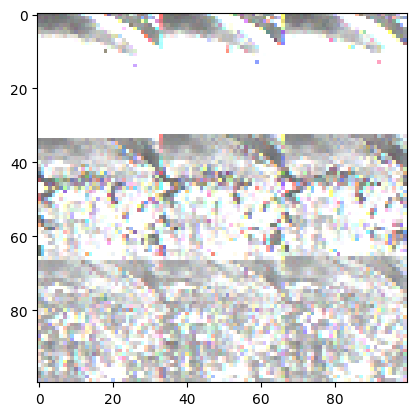

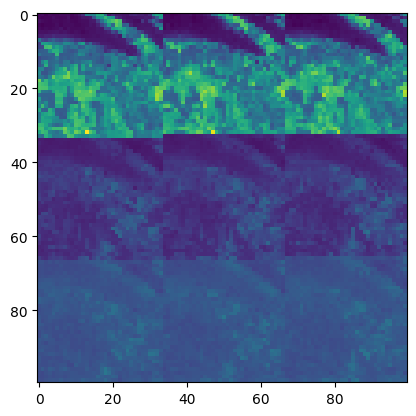

In [10]:
# Let's plot a sample input RGB image and output image with buildings
img = np.random.randint(0, 1768)
print(img)
plt.imshow(train_xx_initial[img, :, :, :3])
plt.show()
plt.imshow(train_yy_initial[img, :, :, 0])
plt.show()

###UNET ARCHITECTURE
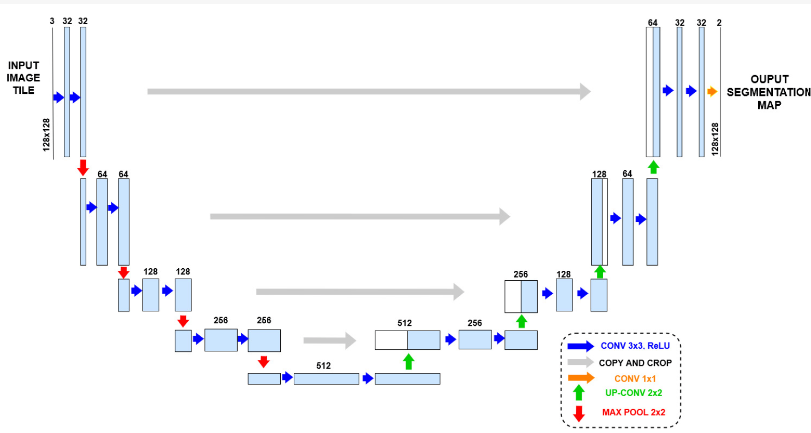

In [ ]:
x_in = Input(shape=(256, 256, 4))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

'''Use 1 by 1 Convolution to get desired output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)
# use sigmoid activation here because output values are either 0 or 1

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss='binary_crossentropy', optimizer='adam')

model.summary()

In [ ]:
!pip install tensorflow==2.12.0

In [ ]:
# training model
import tensorflow as tf

# callback function to stop overfitting the model
checkpointer = tf.keras.callbacks.ModelCheckpoint("best_weight.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

callbacks = [
    earlyStopping,
    checkpointer
    ]
history = model.fit(train_xx, train_yy,
                    validation_data=(test_xx, test_yy),
                    epochs=50,
                    batch_size=8,
                    verbose=1,
                    callbacks=callbacks)

In [ ]:
# plot model loss over training and validation data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('best_weight.h5')

In [ ]:
threshold = 0.5

# prediction of the output
pred_test = model.predict(test_xx)
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)

#let's comare random predicted and actial y values
img = np.random.randint(0, 282)
plt.imshow(pred_test[img, :, :, 0])
plt.show()
plt.imshow(test_yy[img,:,:,0])
plt.show()

This is not an operational model with high accuracy. But with more layers and with more data, we can develop this architecture in to an operational model with high accuracy.